# Analyze counts and compute escape scores
This Python Jupyter notebook analyzes the variant counts and looks at mutation coverage and jackpotting.
It then computes an "escape scores" for each variant after grouping by barcode or substitutions as specified in the configuration.

## Set up analysis

This notebook primarily makes use of the Bloom lab's [dms_variants](https://jbloomlab.github.io/dms_variants) package, and uses [plotnine](https://github.com/has2k1/plotnine) for ggplot2-like plotting syntax:

In [1]:
import collections
import math
import os
import warnings

import Bio.SeqIO

import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy

import pandas as pd

from plotnine import *

import seaborn

import yaml

Set [plotnine](https://github.com/has2k1/plotnine) theme to the gray-grid one defined in [dms_variants](https://jbloomlab.github.io/dms_variants):

In [2]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

Versions of key software:

In [3]:
print(f"Using dms_variants version {dms_variants.__version__}")

Using dms_variants version 0.8.5


Ignore warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Read the configuration file:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [6]:
os.makedirs(config['escape_scores_dir'], exist_ok=True)

Read information about the samples:

In [7]:
samples_df = pd.read_csv(config['barcode_runs'])

## Initialize codon-variant table
Initialize [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) from wildtype gene sequence and the variant counts CSV file.
We will then use the plotting functions of this variant table to analyze the counts per sample:

In [8]:
wt_seqrecord = Bio.SeqIO.read(config['wildtype_sequence'], 'fasta')
geneseq = str(wt_seqrecord.seq)
primary_target = wt_seqrecord.name
print(f"Read sequence of {len(geneseq)} nt for {primary_target} from {config['wildtype_sequence']}")
      
print(f"Initializing CodonVariantTable from gene sequence and {config['variant_counts']}")
      
variants = dms_variants.codonvarianttable.CodonVariantTable.from_variant_count_df(
                geneseq=geneseq,
                variant_count_df_file=config['variant_counts'],
                primary_target=primary_target)
      
print('Done initializing CodonVariantTable.')

Read sequence of 603 nt for SARS-CoV-2 from data/wildtype_sequence.fasta
Initializing CodonVariantTable from gene sequence and results/counts/variant_counts.csv.gz
Done initializing CodonVariantTable.


## Sequencing counts per sample
Average counts per variant for each sample.
Note that these are the **sequencing** counts, in some cases they may outstrip the actual number of sorted cells:

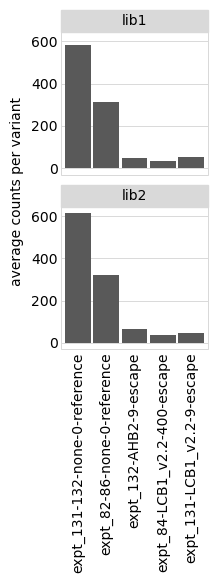

In [9]:
p = variants.plotAvgCountsPerVariant(libraries=variants.libraries,
                                     by_target=False,
                                     orientation='v')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

And the numerical values plotted above:

In [10]:
display(HTML(
 variants.avgCountsPerVariant(libraries=variants.libraries,
                               by_target=False)
 .pivot_table(index='sample',
              columns='library',
              values='avg_counts_per_variant')
 .round(1)
 .to_html()
 ))

library,lib1,lib2
sample,,
expt_131-132-none-0-reference,584.4,612.5
expt_82-86-none-0-reference,313.7,323.0
expt_132-AHB2-9-escape,47.9,63.8
expt_84-LCB1_v2.2-400-escape,32.6,34.8
expt_131-LCB1_v2.2-9-escape,51.9,47.0


## Mutations per variant
Average number of mutations per gene among all variants of the primary target, separately for each date:

In [11]:
# this plotting is very slow when lots of samples, so for now plots are commented out

#for date, date_df in samples_df.groupby('date', sort=False):
#    p = variants.plotNumCodonMutsByType(variant_type='all',
#                                        orientation='v',
#                                        libraries=variants.libraries,
#                                        samples=date_df['sample'].unique().tolist(),
#                                        widthscale=2)
#    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
#    fig = p.draw()
#    display(fig)
#    plt.close(fig)

Now similar plots but showing mutation frequency across the gene:

In [12]:
# this plotting is very slow when lots of samples, so for now code commented out

# for date, date_df in samples_df.groupby('date', sort=False):
#    p = variants.plotMutFreqs(variant_type='all',
#                              mut_type='codon',
#                              orientation='v',
#                              libraries=variants.libraries,
#                              samples=date_df['sample'].unique().tolist(),
#                              widthscale=1.5)
#    fig = p.draw()
#    display(fig)
#    plt.close(fig)

## Jackpotting and mutation coverage in pre-selection libraries
We look at the distribution of counts in the "reference" (pre-selection) libraries to see if they seem jackpotted (a few variants at very high frequency):

In [13]:
pre_samples_df = samples_df.query('selection == "reference"')

Distribution of mutations along the gene for the pre-selection samples; big spikes may indicate jackpotting:

In [14]:
# this plotting is very slow when lots of samples, so for now code commented out

#p = variants.plotMutFreqs(variant_type='all',
#                          mut_type='codon',
#                          orientation='v',
#                          libraries=variants.libraries,
#                          samples=pre_samples_df['sample'].unique().tolist(),
#                          widthscale=1.5)
#_ = p.draw()

How many mutations are observed frequently in pre-selection libraries?
Note that the libraries have been pre-selected for ACE2 binding, so we expect stop variants to mostly be missing.
Make the plot both for all variants and just single-mutant variants:

In [15]:
# this plotting is very slow when lots of samples, so for now code commented out

#for variant_type in ['all', 'single']:
#    p = variants.plotCumulMutCoverage(
#                          variant_type=variant_type,
#                          mut_type='aa',
#                          orientation='v',
#                          libraries=variants.libraries,
#                          samples=pre_samples_df['sample'].unique().tolist(),
#                          widthscale=1.8,
#                          heightscale=1.2)
#    _ = p.draw()

Now make a plot showing what number and fraction of counts are for each variant in each pre-selection sample / library.
If some variants constitute a very high fraction, then that indicates extensive bottlenecking:

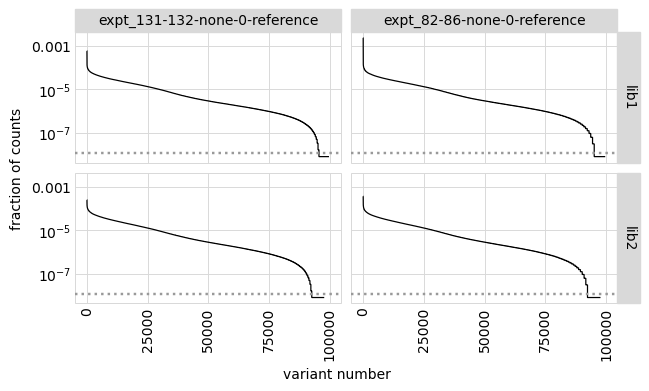

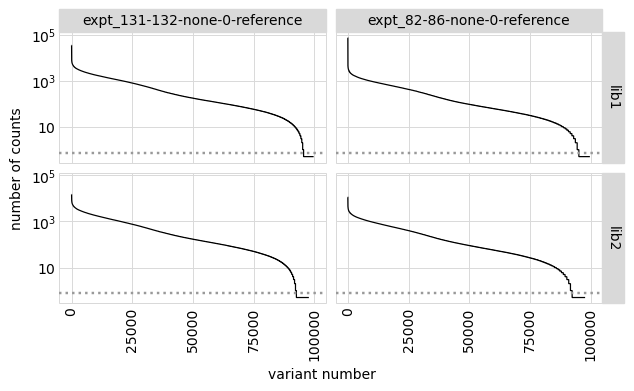

In [16]:
for ystat in ['frac_counts', 'count']:
    p = variants.plotCountsPerVariant(ystat=ystat,
                                      libraries=variants.libraries,
                                      samples=pre_samples_df['sample'].unique().tolist(),
                                      orientation='v',
                                      widthscale=1.75,
                                      )
    _ = p.draw()

Now make the same plot breaking down by variant class, which enables determination of which types of variants are at high and low frequencies.
For this plot (unlike one above not classified by category) we only show variants of the primary target (not the homologs), and also group synonymous with wildtype in order to reduce number of plotted categories to make more interpretable:

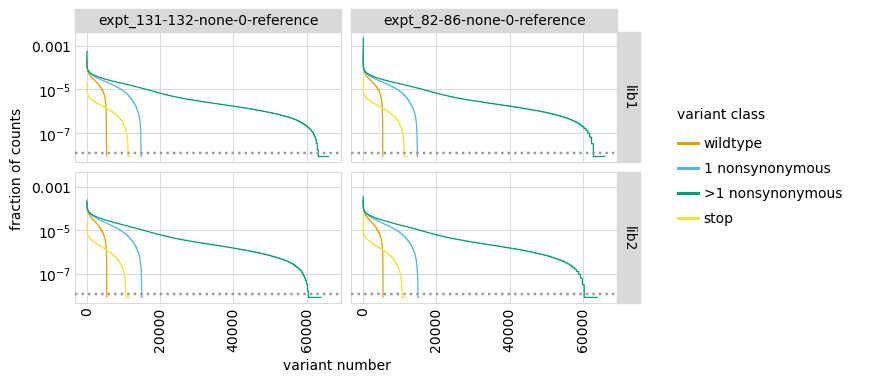

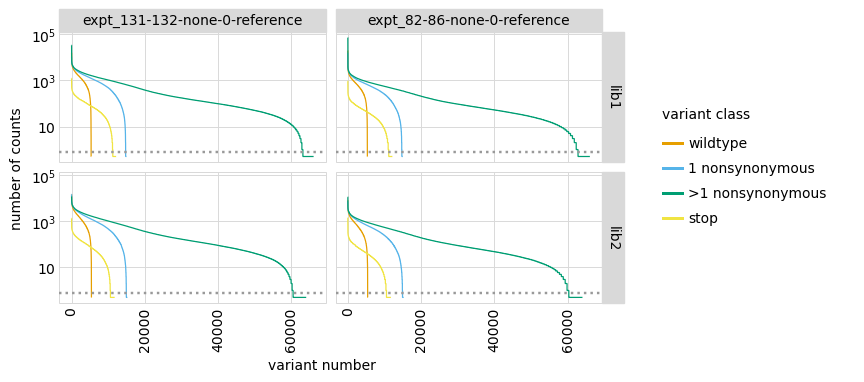

In [17]:
for ystat in ['frac_counts', 'count']:
    p = variants.plotCountsPerVariant(ystat=ystat,
                                      libraries=variants.libraries,
                                      samples=pre_samples_df['sample'].unique().tolist(),
                                      orientation='v',
                                      widthscale=1.75,
                                      by_variant_class=True,
                                      classifyVariants_kwargs={'syn_as_wt': True},
                                      primary_target_only=True,
                                      )
    _ = p.draw()

We also directly look to see what is the variant in each reference library / sample with the highest fraction counts.
Knowing if the highest frequency variant is shared helps determine **where** in the experiment the jackpotting happened:

In [18]:
frac_counts_per_variant = (
        variants.add_frac_counts(variants.variant_count_df)
        .query(f"sample in {pre_samples_df['sample'].unique().tolist()}")
        )

display(HTML(
    frac_counts_per_variant
    .sort_values('frac_counts', ascending=False)
    .groupby(['library', 'sample'])
    .head(n=1)
    .sort_values(['library', 'sample'])
    .set_index(['library', 'sample'])
    [['frac_counts', 'target', 'barcode', 'aa_substitutions', 'codon_substitutions']]
    .round(4)
    .to_html()
    ))

To further where the jackpotting relative to the generation of the reference samples, we plot the correlation among the fraction of counts for the different reference samples.
If the fractions are highly correlated, that indicates that the jackpotting occurred in some upstream step common to the reference samples:

In [19]:
# this code makes a full matrix of scatter plots, but is REALLY SLOW. So for now,
# it is commented out in favor of code that just makes correlation matrix.
#for lib, lib_df in frac_counts_per_variant.groupby('library'):
#    wide_lib_df = lib_df.pivot_table(index=['target', 'barcode'],
#                                     columns='sample',
#                                     values='frac_counts')
#    g = seaborn.pairplot(wide_lib_df, corner=True, plot_kws={'alpha': 0.5}, diag_kind='kde')
#    _ = g.fig.suptitle(lib, size=18)
#    plt.show()

## Examine counts for wildtype variants
The type of score we use to quantify escape depends on how well represented wildtype is in the selected libraries.
If wildtype is still well represented, we can use a more conventional functional score that gives differential selection relative to wildtype.
If wildtype is not well represented, then we need an alternative score that does not involve normalizing frequencies to wildtype.

First get average fraction of counts per variant for each variant class:

In [20]:
counts_by_class = (
    variants.variant_count_df
    .pipe(variants.add_frac_counts)
    .pipe(variants.classifyVariants,
          primary_target=variants.primary_target,
          non_primary_target_class='homolog',
          class_as_categorical=True)
    .groupby(['library', 'sample', 'variant_class'])
    .aggregate(avg_frac_counts=pd.NamedAgg('frac_counts', 'mean'))
    .reset_index()
    .merge(samples_df[['sample', 'library', 'date', 'antibody', 'concentration', 'selection']],
           on=['sample', 'library'], validate='many_to_one')
    )

display(HTML(counts_by_class.head().to_html(index=False)))

library,sample,variant_class,avg_frac_counts,date,antibody,concentration,selection
lib1,expt_131-132-none-0-reference,wildtype,0.000026,210618,none,0,reference
lib1,expt_131-132-none-0-reference,synonymous,0.000025,210618,none,0,reference
lib1,expt_131-132-none-0-reference,1 nonsynonymous,0.000020,210618,none,0,reference
lib1,expt_131-132-none-0-reference,>1 nonsynonymous,0.000008,210618,none,0,reference
lib1,expt_131-132-none-0-reference,stop,0.000002,210618,none,0,reference


Plot average fraction of all counts per variant for each variant class.
If the values for wildtype are low for the non-reference samples (such as more similar to stop the nonsynonymous), then normalizing by wildtype in calculating scores will probably not work well as wildtype is too depleted:

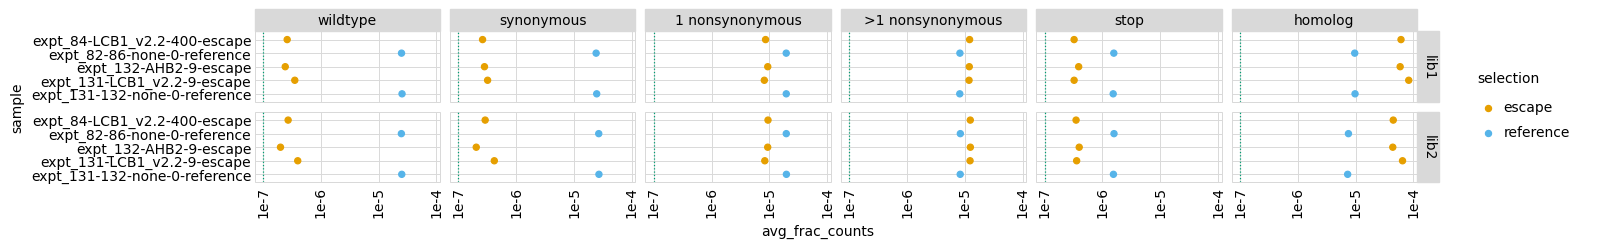

In [21]:
min_frac = 1e-7  # plot values < this as this

p = (ggplot(counts_by_class
            .assign(avg_frac_counts=lambda x: numpy.clip(x['avg_frac_counts'], min_frac, None))
            ) +
     aes('avg_frac_counts', 'sample', color='selection') +
     geom_point(size=2) +
     scale_color_manual(values=CBPALETTE[1:]) +
     facet_grid('library ~ variant_class') +
     scale_x_log10() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2.5 * counts_by_class['variant_class'].nunique(),
                        0.2 * counts_by_class['library'].nunique() * 
                        counts_by_class['sample'].nunique())
           ) +
     geom_vline(xintercept=min_frac, linetype='dotted', color=CBPALETTE[3])
     )

_ = p.draw()

## Compute escape scores
We use the escape score metric, which does **not** involve normalizing to wildtype and so isn't strongly affected by low wildtype counts.
We compute the scores using the method [dms_variants.codonvarianttable.CodonVariantTable.escape_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html?highlight=escape_scores#dms_variants.codonvarianttable.CodonVariantTable.escape_scores).

First, define what samples to compare for each calculation, matching each post-selection (escape) to the pre-selection (reference) sample on the same date:

In [22]:
score_sample_df = (
    samples_df
    .query('selection == "escape"')
    .rename(columns={'sample': 'post_sample',
                     'cells_sorted': 'pre_cells_sorted'})
    .merge(samples_df
           .query('selection == "reference"')
           [['sample', 'library', 'date', 'cells_sorted']]
           .rename(columns={'sample': 'pre_sample',
                            'cells_sorted': 'post_cells_sorted'}),
           how='left', on=['date', 'library'], validate='many_to_one',
           )
    .assign(name=lambda x: x['antibody'] + '_' + x['concentration'].astype(str))
    # add dates to names where needed to make unique
    .assign(n_libs=lambda x: x.groupby(['name', 'date'])['pre_sample'].transform('count'))
    .sort_values(['name', 'date', 'n_libs'], ascending=False)
    .assign(i_name=lambda x: x.groupby(['library', 'name'], sort=False)['pre_sample'].cumcount(),
            name=lambda x: x.apply(lambda r: r['name'] + '_' + str(r['date']) if r['i_name'] > 0 else r['name'],
                                   axis=1),
            )
    .sort_values(['antibody', 'concentration', 'library', 'i_name'])
    # get columns of interest
    [['name', 'library', 'antibody', 'concentration', 'concentration_units', 'date',
      'pre_sample', 'post_sample', 'frac_escape', 'pre_cells_sorted', 'post_cells_sorted']]
    )

assert len(score_sample_df.groupby(['name', 'library'])) == len(score_sample_df)

print(f"Writing samples used to compute escape scores to {config['escape_score_samples']}\n")
score_sample_df.to_csv(config['escape_score_samples'], index=False)

display(HTML(score_sample_df.to_html(index=False)))

Writing samples used to compute escape scores to results/escape_scores/samples.csv



name,library,antibody,concentration,concentration_units,date,pre_sample,post_sample,frac_escape,pre_cells_sorted,post_cells_sorted
AHB2_9,lib1,AHB2,9,ng_per_mL,210618,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,0.123,1301648.0,NaN
AHB2_9,lib2,AHB2,9,ng_per_mL,210618,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,0.120,1330108.0,NaN
LCB1_v2.2_9,lib1,LCB1_v2.2,9,ng_per_mL,210618,expt_131-132-none-0-reference,expt_131-LCB1_v2.2-9-escape,0.083,902912.0,NaN
LCB1_v2.2_9,lib2,LCB1_v2.2,9,ng_per_mL,210618,expt_131-132-none-0-reference,expt_131-LCB1_v2.2-9-escape,0.076,900790.0,NaN
LCB1_v2.2_400,lib1,LCB1_v2.2,400,ng_per_mL,210115,expt_82-86-none-0-reference,expt_84-LCB1_v2.2-400-escape,0.089,971158.0,NaN
LCB1_v2.2_400,lib2,LCB1_v2.2,400,ng_per_mL,210115,expt_82-86-none-0-reference,expt_84-LCB1_v2.2-400-escape,0.096,1041736.0,NaN


Compute the escape scores for variants of the primary target and classify the variants, then compute escape scores for homologs:

In [23]:
print(f"Computing escape scores for {primary_target} variants using {config['escape_score_type']} "
      f"score type with a pseudocount of {config['escape_score_pseudocount']} and "
      f"an escape fraction floor {config['escape_score_floor_E']}, an escape fraction ceiling "
      f"{config['escape_score_ceil_E']}, and grouping variants by {config['escape_score_group_by']}.")

escape_scores = (variants.escape_scores(score_sample_df,
                                        score_type=config['escape_score_type'],
                                        pseudocount=config['escape_score_pseudocount'],
                                        floor_E=config['escape_score_floor_E'],
                                        ceil_E=config['escape_score_ceil_E'],
                                        by=config['escape_score_group_by'],
                                        )
                 .query('target == @primary_target')
                 .pipe(variants.classifyVariants,
                       primary_target=variants.primary_target,
                       syn_as_wt=(config['escape_score_group_by'] == 'aa_substitutions'),
                       )
                 )
print('Here are the first few lines of the resulting escape scores:')
display(HTML(escape_scores.head().to_html(index=False)))

print(f"\nComputing scores for homologs grouping by {config['escape_score_homolog_group_by']}")

escape_scores_homologs = (
        variants.escape_scores(score_sample_df,
                               score_type=config['escape_score_type'],
                               pseudocount=config['escape_score_pseudocount'],
                               floor_E=config['escape_score_floor_E'],
                               ceil_E=config['escape_score_ceil_E'],
                               by=config['escape_score_homolog_group_by'],
                               )
        .query('(target != @primary_target) | (n_aa_substitutions == 0)')
        )

print('Here are the first few lines of the resulting homolog escape scores:')
display(HTML(escape_scores_homologs.head().to_html(index=False)))

Computing escape scores for SARS-CoV-2 variants using frac_escape score type with a pseudocount of 0.5 and an escape fraction floor 0, an escape fraction ceiling 1, and grouping variants by barcode.
Here are the first few lines of the resulting escape scores:


name,target,library,pre_sample,post_sample,barcode,score,score_var,pre_count,post_count,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions,variant_class
AHB2_9,SARS-CoV-2,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,TTCCAAAATATTGTCA,0.000712,3.077886e-08,34432,16,GAT59AAC TTT156TCG,2,D59N F156S,2,>1 nonsynonymous
AHB2_9,SARS-CoV-2,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,TAGTAACAATGCGGTA,0.000047,4.452101e-09,15756,0,,0,,0,wildtype
AHB2_9,SARS-CoV-2,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,AAAAAACATCTGCATG,0.000068,9.160727e-09,10984,0,,0,,0,wildtype
AHB2_9,SARS-CoV-2,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,TGAGAATCTATCATGA,0.002925,3.987195e-07,10928,21,ATC2CTG GTC11CTG,2,I2L V11L,2,>1 nonsynonymous
AHB2_9,SARS-CoV-2,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,GATTCCGCATTGCAGT,0.000069,9.549651e-09,10758,0,GTC173AAG,1,V173K,1,1 nonsynonymous



Computing scores for homologs grouping by aa_substitutions
Here are the first few lines of the resulting homolog escape scores:


name,target,library,pre_sample,post_sample,aa_substitutions,score,score_var,pre_count,post_count,n_aa_substitutions
AHB2_9,BM48-31,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,BM48-31,0.884316,3.258501e-04,6436,3819,0
AHB2_9,GD-Pangolin,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,GD-Pangolin,0.006402,6.346015e-08,150946,648,0
AHB2_9,HKU3-1,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,HKU3-1,0.872091,2.849483e-04,7220,4225,0
AHB2_9,LYRa11,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,LYRa11,0.968418,6.329226e-05,37369,24284,0
AHB2_9,RaTG13,lib1,expt_131-132-none-0-reference,expt_132-AHB2-9-escape,RaTG13,0.978691,1.777486e-05,132745,87179,0


## Apply pre-selection count filter to variant escape scores
Now determine a pre-selection count filter in order to flag for removal variants with counts that are so low that the estimated score is probably noise.
We know that stop codons should be largely purged pre-selection, and so the counts for them are a good indication of the "noise" threshold.
We therefore set the filter using the number of pre-selection counts for the stop codons.

To do this, we first compute the number of pre-selection counts for stop-codon variants at various quantiles and look at these.
We then take the number of pre-selection counts at the specified quantile as the filter cutoff, and filter scores for all variants with pre-selection counts less than this filter cutoff:

In [24]:
filter_quantile = config['escape_score_stop_quantile_filter']
assert 0 <= filter_quantile <= 1

quantiles = sorted(set([0.5, 0.9, 0.95, 0.98, 0.99, 0.995, 0.999] + [filter_quantile]))

stop_score_counts = (
    escape_scores
    .query('variant_class == "stop"')
    .groupby(['library', 'pre_sample'], observed=True)
    ['pre_count']
    .quantile(q=quantiles)
    .reset_index()
    .rename(columns={'level_2': 'quantile'})
    .pivot_table(index=['pre_sample', 'library'],
                 columns='quantile',
                 values='pre_count')
    )

print('Quantiles of the number of pre-selection counts per variant for stop variants:')
display(HTML(stop_score_counts.to_html(float_format='%.1f')))

print(f"\nSetting the pre-count filter cutoff to the {filter_quantile} quantile:")
pre_count_filter_cutoffs = (
    stop_score_counts
    [filter_quantile]
    .rename('pre_count_filter_cutoff')
    .reset_index()
    )
display(HTML(pre_count_filter_cutoffs.to_html(float_format='%.1f')))

Quantiles of the number of pre-selection counts per variant for stop variants:



Setting the pre-count filter cutoff to the 0.99 quantile:


,pre_sample,library,pre_count_filter_cutoff
0,expt_131-132-none-0-reference,lib1,396.0
1,expt_131-132-none-0-reference,lib2,436.0
2,expt_82-86-none-0-reference,lib1,222.0
3,expt_82-86-none-0-reference,lib2,245.0


Apply the filter to the escape scores, so that scores that fail the pre-selection count filter are now marked with `pass_pre_count_filter` of `False`:

In [25]:
escape_scores = (
    escape_scores
    .merge(pre_count_filter_cutoffs,
           on=['library', 'pre_sample'],
           how='left',
           validate='many_to_one')
    .assign(pass_pre_count_filter=lambda x: x['pre_count'] >= x['pre_count_filter_cutoff'])
    )

escape_scores_homologs = (
    escape_scores_homologs
    .merge(pre_count_filter_cutoffs,
           on=['library', 'pre_sample'],
           how='left',
           validate='many_to_one')
    .assign(pass_pre_count_filter=lambda x: x['pre_count'] >= x['pre_count_filter_cutoff'])
    )

Plot the fraction of variants of each type that pass the pre-selection count filter in each pre-selection sample.
The ideal filter would have the property such that no *stop* variants pass, all *wildtype* (or *synonymous*) variants pass, and some intermediate fraction of *nonsynonymous* variants pass.
However, if the variant composition in the pre-selection samples is already heavily skewed by jackpotting, there will be some deviation from this ideal behavior.
Here is what the plots actually look like:

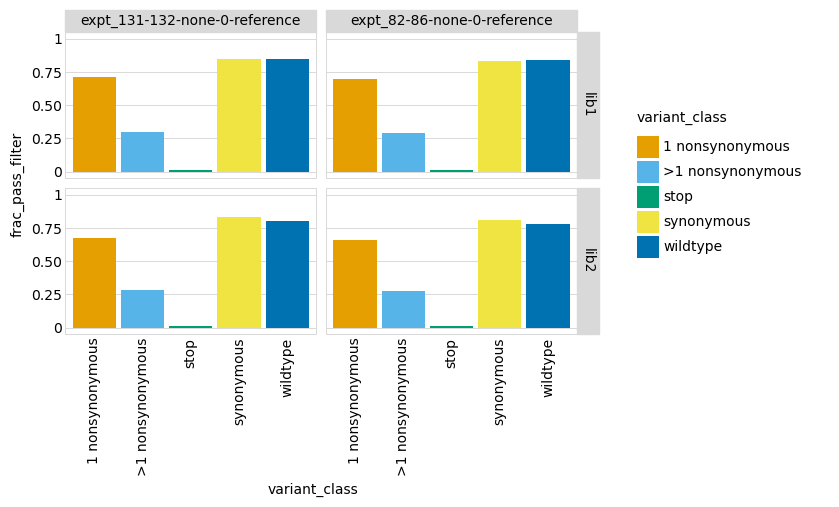

In [26]:
frac_pre_pass_filter = (
    escape_scores
    [['pre_sample', 'library', 'target', config['escape_score_group_by'],
      'pre_count', 'pass_pre_count_filter', 'variant_class']]
    .drop_duplicates()
    .groupby(['pre_sample', 'library', 'variant_class'], observed=True)
    .aggregate(n_variants=pd.NamedAgg('pass_pre_count_filter', 'count'),
               n_pass_filter=pd.NamedAgg('pass_pre_count_filter', 'sum')
               )
    .reset_index()
    .assign(frac_pass_filter=lambda x: x['n_pass_filter'] / x['n_variants'],
            pre_sample=lambda x: pd.Categorical(x['pre_sample'], x['pre_sample'].unique(), ordered=True))
    )

p = (ggplot(frac_pre_pass_filter) +
     aes('variant_class', 'frac_pass_filter', fill='variant_class') +
     geom_bar(stat='identity') +
     facet_grid('library ~ pre_sample') +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(3.3 * frac_pre_pass_filter['pre_sample'].nunique(),
                        2 * frac_pre_pass_filter['library'].nunique()),
           panel_grid_major_x=element_blank(),
           ) +
     scale_fill_manual(values=CBPALETTE[1:]) +
     expand_limits(y=(0, 1))
     )

_ = p.draw()

## Apply ACE2-binding / expression filter to variant mutations
In [Starr et al (2020)](https://www.biorxiv.org/content/10.1101/2020.06.17.157982v1), we used deep mutational scanning to estimate how each mutation affected ACE2 binding and expression.
Here we flag for removal any variants of the primary target that have (or have mutations) that were measured to decrease ACE2-binding or expression beyond a minimal threshold, in order to avoid these variants muddying the signal as spurious escape mutants.

To do this, we first determine all mutations that do / do-not having binding that exceeds the thresholds.
We then flag variants as passing the ACE2-binding / expression filter if all of the mutations they contain exceed both thresholds, and failing as otherwise.
In addition, we look at the measured ACE2-binding / expression for each variant in each library, and flag as passing the filter any variants that have binding / expression that exeed the thresholds, and failing as otherwise.
If we are grouping by amino-acid substitutions, we use the average value for variants with those substitutions.

Note that these filters are only applied to mutants of the primary target; homologs are specified manually for filtering in the configuration file:

In [27]:
print(f"Reading ACE2-binding and expression for mutations from {config['mut_bind_expr']}, "
      f"and for variants from {config['variant_bind']} and {config['variant_expr']}, "
      f"and filtering for variants with binding >={config['escape_score_min_bind_variant']}."
      f"and expression >= {config['escape_score_min_expr_variant']}, and also variants that "
      f"only have mutations with binding >={config['escape_score_min_bind_mut']} and "
      f"expression >={config['escape_score_min_expr_mut']}.")

# filter on mutations
mut_bind_expr = pd.read_csv(config['mut_bind_expr'])
assert mut_bind_expr['mutation_RBD'].nunique() == len(mut_bind_expr)
for prop in ['bind', 'expr']:
    muts_adequate = set(mut_bind_expr
                        .query(f"{prop}_avg >= {config[f'escape_score_min_{prop}_mut']}")
                        ['mutation_RBD']
                        )
    print(f"{len(muts_adequate)} of {len(mut_bind_expr)} mutations have adequate {prop}.")
    escape_scores[f"muts_pass_{prop}_filter"] = (
        escape_scores
        ['aa_substitutions']
        .map(lambda s: set(s.split()).issubset(muts_adequate))
        ) 

# filter on variants
for prop, col in [('bind', 'delta_log10Ka'), ('expr', 'delta_ML_meanF')]:
    filter_name = f"variant_pass_{prop}_filter"
    variant_pass_df = (
        pd.read_csv(config[f"variant_{prop}"], keep_default_na=False, na_values=['NA'])
        .groupby(['library', 'target', config['escape_score_group_by']])
        .aggregate(val=pd.NamedAgg(col, 'mean'))
        .reset_index()
        .assign(pass_filter=lambda x: x['val'] >= config[f"escape_score_min_{prop}_variant"])
        .rename(columns={'pass_filter': filter_name,
                         'val': f"variant_{prop}"})
        )
    print(f"\nTotal variants of {primary_target} that pass {prop} filter:")
    display(HTML(
        variant_pass_df
        .groupby(['library', filter_name])
        .aggregate(n_variants=pd.NamedAgg(config['escape_score_group_by'], 'count'))
        .to_html()
        ))
    escape_scores = (
        escape_scores
        .drop(columns=filter_name, errors='ignore')
        .merge(variant_pass_df,
               how='left',
               validate='many_to_one',
               on=['library', 'target', config['escape_score_group_by']],
               )
        )
    assert escape_scores[filter_name].notnull().all()

# annotate as passing overall filter if passes all mutation and binding filters:
escape_scores['pass_ACE2bind_expr_filter'] = (
        escape_scores['muts_pass_bind_filter'] &
        escape_scores['muts_pass_expr_filter'] &
        escape_scores['variant_pass_bind_filter'] &
        escape_scores['variant_pass_expr_filter']
        )

Reading ACE2-binding and expression for mutations from results/prior_DMS_data/mutant_ACE2binding_expression.csv, and for variants from results/prior_DMS_data/variant_ACE2binding.csv and results/prior_DMS_data/variant_expression.csv, and filtering for variants with binding >=-2.35.and expression >= -1.0, and also variants that only have mutations with binding >=-2.35 and expression >=-1.0.
3422 of 4221 mutations have adequate bind.
2328 of 4221 mutations have adequate expr.

Total variants of SARS-CoV-2 that pass bind filter:



Total variants of SARS-CoV-2 that pass expr filter:


Plot the fraction of variants that **have already passed the pre-count filter** that are filtered by the ACE2-binding or expression thresholds:

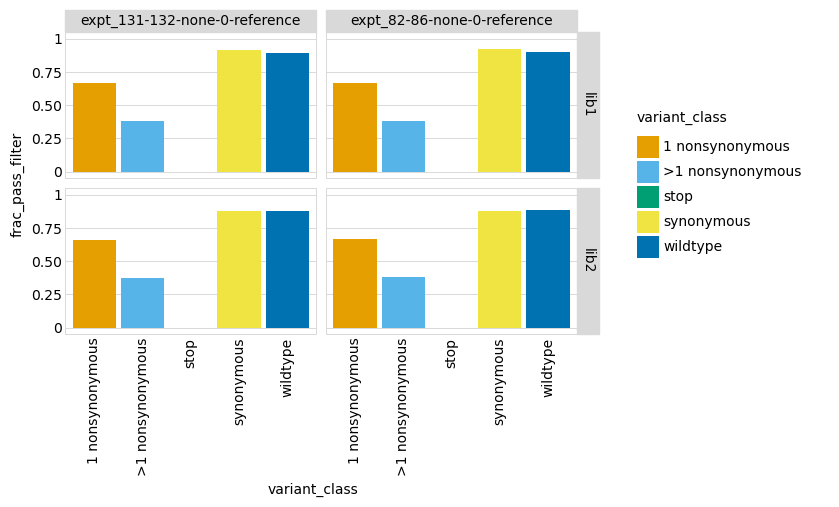

In [28]:
frac_ACE2bind_expr_pass_filter = (
    escape_scores
    .query('pass_pre_count_filter == True')
    [['pre_sample', 'library', 'target', config['escape_score_group_by'],
      'pre_count', 'pass_ACE2bind_expr_filter', 'variant_class']]
    .drop_duplicates()
    .groupby(['pre_sample', 'library', 'variant_class'], observed=True)
    .aggregate(n_variants=pd.NamedAgg('pass_ACE2bind_expr_filter', 'count'),
               n_pass_filter=pd.NamedAgg('pass_ACE2bind_expr_filter', 'sum')
               )
    .reset_index()
    .assign(frac_pass_filter=lambda x: x['n_pass_filter'] / x['n_variants'],
            pre_sample=lambda x: pd.Categorical(x['pre_sample'], x['pre_sample'].unique(), ordered=True))
    )

p = (ggplot(frac_ACE2bind_expr_pass_filter) +
     aes('variant_class', 'frac_pass_filter', fill='variant_class') +
     geom_bar(stat='identity') +
     facet_grid('library ~ pre_sample') +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(3.3 * frac_ACE2bind_expr_pass_filter['pre_sample'].nunique(),
                        2 * frac_ACE2bind_expr_pass_filter['library'].nunique()),
           panel_grid_major_x=element_blank(),
           ) +
     scale_fill_manual(values=CBPALETTE[1:]) +
     expand_limits(y=(0, 1))
     )

_ = p.draw()

## Examine and write escape scores
Plot the distribution of escape scores across variants of different classes **among those that pass both the pre-selection count filter and the ACE2-binding / expression filter**.
If things are working correctly, we don't expect escape in wildtype (or synonymous variants), but do expect escape for some small fraction of nonsynymous variants.
Also, we do not plot the scores for the stop codon variant class, as most stop-codon variants have already been filtered out so this category is largely noise:

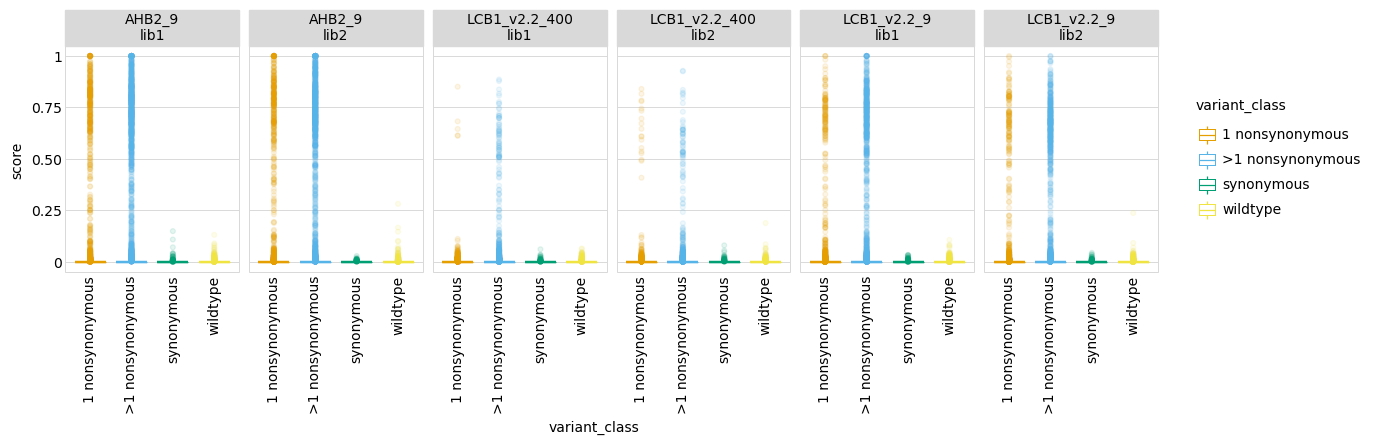

In [29]:
nfacets = len(escape_scores.groupby(['library', 'name']).nunique())
ncol = min(8, nfacets)
nrow = math.ceil(nfacets / ncol)

df = (escape_scores
      .query('(pass_pre_count_filter == True) & (pass_ACE2bind_expr_filter == True)')
      .query('variant_class != "stop"')
      )
     
p = (ggplot(df) +
     aes('variant_class', 'score', color='variant_class') +
     geom_boxplot(outlier_size=1.5, outlier_alpha=0.1) +
     facet_wrap('~ name + library', ncol=ncol) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2.35 * ncol, 3 * nrow),
           panel_grid_major_x=element_blank(),
           ) +
     scale_fill_manual(values=CBPALETTE[1:]) +
     scale_color_manual(values=CBPALETTE[1:])
     )

_ = p.draw()

Also, we want to see how much the high escape scores are correlated with simple coverage.
To do this, we plot the correlation between escape score and pre-selection count just for the nonsynonymous variants (which are the ones that we expect to have true escape).
The plots below have a lot of overplotting, but are still sufficient to test of the score is simply correlated with the pre-selection counts or not.
The hoped for result is that the escape score doesn't appear to be strongly correlated with pre-selection counts:

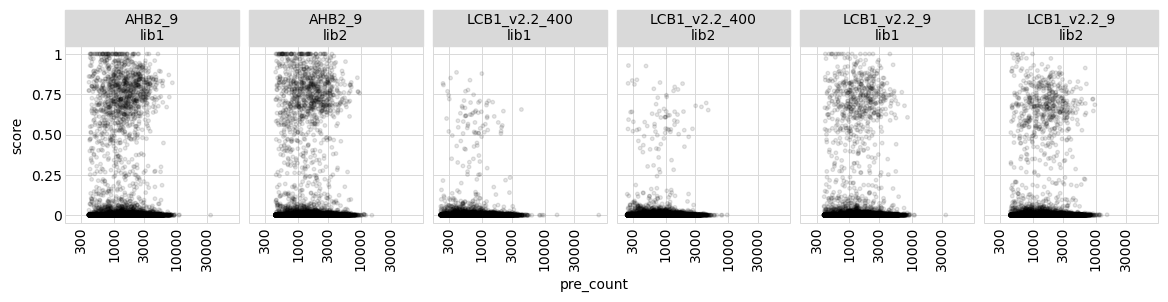

In [30]:
p = (ggplot(escape_scores
            .query('(pass_pre_count_filter == True) & (pass_ACE2bind_expr_filter == True)')
            .query('variant_class in ["1 nonsynonymous", ">1 nonsynonymous"]')
            ) +
     aes('pre_count', 'score') +
     geom_point(alpha=0.1, size=1) +
     facet_wrap('~ name + library', ncol=ncol) +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(2.35 * ncol, 2.35 * nrow),
           ) +
     scale_fill_manual(values=CBPALETTE[1:]) +
     scale_color_manual(values=CBPALETTE[1:]) +
     scale_x_log10()
     )

_ = p.draw()

Write the escape scores to a file:

In [31]:
print(f"Writing escape scores for {primary_target} to {config['escape_scores']}")
escape_scores.to_csv(config['escape_scores'], index=False, float_format='%.4g', compression='gzip')

print(f"Writing escape scores for homologs to {config['escape_scores_homologs']}")
escape_scores_homologs.to_csv(config['escape_scores_homologs'], index=False, float_format='%.4g')

Writing escape scores for SARS-CoV-2 to results/escape_scores/scores.csv.gz
Writing escape scores for homologs to results/escape_scores/scores_homologs.csv
